In [34]:
from loica import *
import matplotlib.pyplot as plt
import numpy as np
import getpass

In [35]:
from flapjack import *
#fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

Flapjack username: tim
Password: ········


In [41]:
receiver1_vector = fj.get('vector', name='receiver1')
receiver2_vector = fj.get('vector', name='receiver2')

In [44]:
study = fj.create('study', name='Loica testing', description='Test study for demonstrating Loica')

One or more study already exists, type "yes" to replace them:


In [45]:
dna = fj.create('dna', name='nor')
vector = fj.create('vector', name='nor', dnas=dna.id)

One or more dna already exists, type "yes" to replace them:
One or more vector already exists, type "yes" to replace them:


In [46]:
network = GeneticNetwork(vector=vector.id[0])

In [47]:
sfp = fj.create('signal', name='SFP', color='green', description='Simulated fluorescent protein')
reporter = Reporter(name='SFP', color='green', degradation_rate=0, init_concentration=0, signal_id=sfp.id[0])

One or more signal already exists, type "yes" to replace them:


In [48]:
network.add_reporter(reporter)

In [49]:
ahl1 = Supplement(name='AHL1')
repressor1 = Regulator('LacI')
rec1 = Receiver(input=ahl1, output=repressor1, a=0, b=1000, K=1, n=2)

ahl2 = Supplement(name='AHL2')
repressor2 = Regulator('TetR')
rec2 = Receiver(input=ahl2, output=repressor2, a=0, b=1000, K=1, n=2)

network.add_operators([rec1,rec2])
network.add_regulators([repressor1,repressor2])

In [50]:
nor = Nor(input=[repressor1, repressor2], output=reporter, alpha=[1,0.5,0.5,0], K=[1,10], n=[2,4])

In [51]:
network.add_operator(nor)

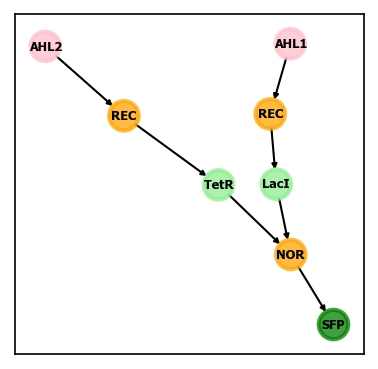

In [52]:
plt.figure(figsize=(3,3), dpi=150)
network.draw()

In [53]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.05, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.05, 1, 1, 1)
    
metab = SimulatedMetabolism(biomass, growth_rate)

media = fj.create('media', name='loica', description='Simulated loica media')
strain = fj.create('strain', name='loica', description='Loica test strain')

One or more media already exists, type "yes" to replace them:
One or more strain already exists, type "yes" to replace them:


In [54]:
# Create list of samples    
samples = []
for conc1 in np.append(0, np.logspace(-6, 6, 24)):
    for conc2 in np.append(0, np.logspace(-6, 6, 24)):
        sample = Sample(genetic_network=network, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.add_supplement(ahl1, conc1)
        sample.add_supplement(ahl2, conc2)
        samples.append(sample)

In [55]:
biomass_signal = fj.create('signal', name='SOD', description='Simulated OD', color='black')

One or more signal already exists, type "yes" to replace them:


In [56]:
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica NOR',
              description='Simulated NOR generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=0)

In [57]:
assay.upload(fj, study.id[0])

One or more assay already exists, type "yes" to replace them:yes


In [ ]:
nor.characterize(fj, 
            receiver1_vector.id,
            receiver2_vector.id, 
            vector.id, 
            media.id, 
            strain.id, 
            sfp.id, 
            biomass_signal.id,
            0
            )

100%|█████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


Returning dataframe


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.60it/s]


Returning dataframe


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 194.30it/s]


Returning dataframe


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 166.90it/s]


Returning dataframe


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 189.37it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.11it/s]


Returning dataframe


In [ ]:
nor.alpha0, nor.alpha1, nor.alpha2, nor.alpha3

In [ ]:
nor.rep1_K, nor.rep1_n

In [ ]:
nor.rep2_K, nor.rep2_n